In [1]:
from after_tunning import Eval_Dataset, GraphEmbeddingOnly
from src.tunning_gcnn_lstm_nasdaq30 import *

PROJECT_PATH = os.path.abspath('..')
sys.path.append(PROJECT_PATH)

/home/sam/miniconda3/envs/torch-cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
recurent = False

PATH = '/home/sam/mingsong/ChatgptGraph/GCNNwLSTM'

l = 60
r = 1

file_name = 'nn_weightsgcnn_lstm_seq_60'
PATH = os.path.join(PATH, file_name)
state_dict = torch.load(PATH)


in_MLP = None #[[128,None],[128,None]]
out_MLP = [[512,None],[128,None],[128,None]]
our_model = GraphEmbeddingOnly(22,256,[128,256],3,[4,4],in_MLP ,out_MLP,recurrent_training=recurent)

# load model
our_model.load_state_dict(state_dict, strict=False)
our_model.eval()

# data

with open(PROJECT_PATH + "/data/ticker_train_data.json") as json_file:
    ticker_train_data = json.load(json_file)
json_wrapper = From_Jason_File(ticker_train_data)

with open(PROJECT_PATH + "/data/ticker_test_data.json") as json_file:
    ticker_test_data = json.load(json_file)
test_json_wrapper = From_Jason_File(ticker_test_data)

TICKERS = ['HD', 'INTC', 'JPM', 'CAT', 'WMT', 'HON', 'JNJ', 'AXP', 'DIS', 'UNH', 'CVX', 'PG', 'NKE', 'IBM', 'CRM', 'AMGN', 'KO', 'BA', 'CSCO', 'TRV', 'AAPL', 'MSFT', 'DOW', 'MRK', 'MMM', 'WBA', 'V', 'GS', 'MCD', 'VZ']
TICKERS_IDX = {ticker:i for i,ticker in enumerate(TICKERS)}

price = stock_time_series.get_stock_price(TICKERS, os.path.join(PROJECT_PATH,'data'))
price = price.squeeze()
price = torch.tensor(price, dtype=torch.float32)

stock_feature = stock_time_series.get_stock_feature(TICKERS, os.path.join(PROJECT_PATH,'data'))
stock_feature = torch.tensor(stock_feature, dtype=torch.float32)

tag = np.stack([1*((price[i+1]/price[i])>=1.01) + 1*((price[i+1]/price[i])>.99) for i in range(price.shape[0]-1)])
tag = torch.tensor(tag, dtype=torch.long)


positive_rel = json_wrapper.get_graphs()
negative_rel = json_wrapper.get_graphs(relation_type='negative')

n = len(positive_rel)

tA = np.stack([adjacent_matrix(positive_rel[i-r:i], negative_rel[i-r:i],TICKERS_IDX) for i in range(r,n+1)])
tA = torch.tensor(tA, dtype= torch.long)

n = min(price.shape[0],stock_feature.shape[0], n)
m = len(TICKERS)


# test part 

positive_rel = test_json_wrapper.get_graphs()
negative_rel = test_json_wrapper.get_graphs(relation_type='negative')

n_test = len(positive_rel)

test_tA = np.stack([adjacent_matrix(positive_rel[i-r:i], negative_rel[i-r:i],TICKERS_IDX) for i in range(r,n_test+1)])

sep_point = n
n_test = min(price.shape[0]-sep_point, stock_feature.shape[0]-n_test,n_test)

end_point = n_test+sep_point


batch_size = 1
mask_size = 30



our_data_set = Eval_Dataset(stock_feature[r-1:sep_point], tag[r-1:sep_point], tA[:sep_point+1-r], l,mask_size, recurrent_training=recurent)

test_ds = Eval_Dataset(stock_feature[sep_point+r-1:end_point], tag[sep_point+r-1:end_point], test_tA[:n_test+1-r], l, mask_size,recurrent_training=recurent)

seq_stock,tag,seq_graph = our_data_set[0]

seq_gcnn_embedding, seq_graph_embedding, lstm_hidden_embedding = our_model(seq_stock,seq_graph)

/home/sam/mingsong/ChatgptGraph/data/wrds.csv


/home/sam/mingsong/ChatgptGraph/GCNNwLSTM/src/data_process/stock_time_series.py:48: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  wrds = pd.read_csv(path_to_csv)
/home/sam/mingsong/ChatgptGraph/GCNNwLSTM/src/data_process/stock_time_series.py:82: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  wrds = pd.read_csv(path_to_csv)


In [3]:
lstm_hidden_embedding = lstm_hidden_embedding.detach().numpy()
seq_graph_embedding = seq_graph_embedding.detach().numpy()
seq_gcnn_embedding = seq_gcnn_embedding.detach().numpy()

In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# position = TSNE(n_components=2,perplexity=5).fit_transform(total_z)
# position = position.reshape(-1,30,2)


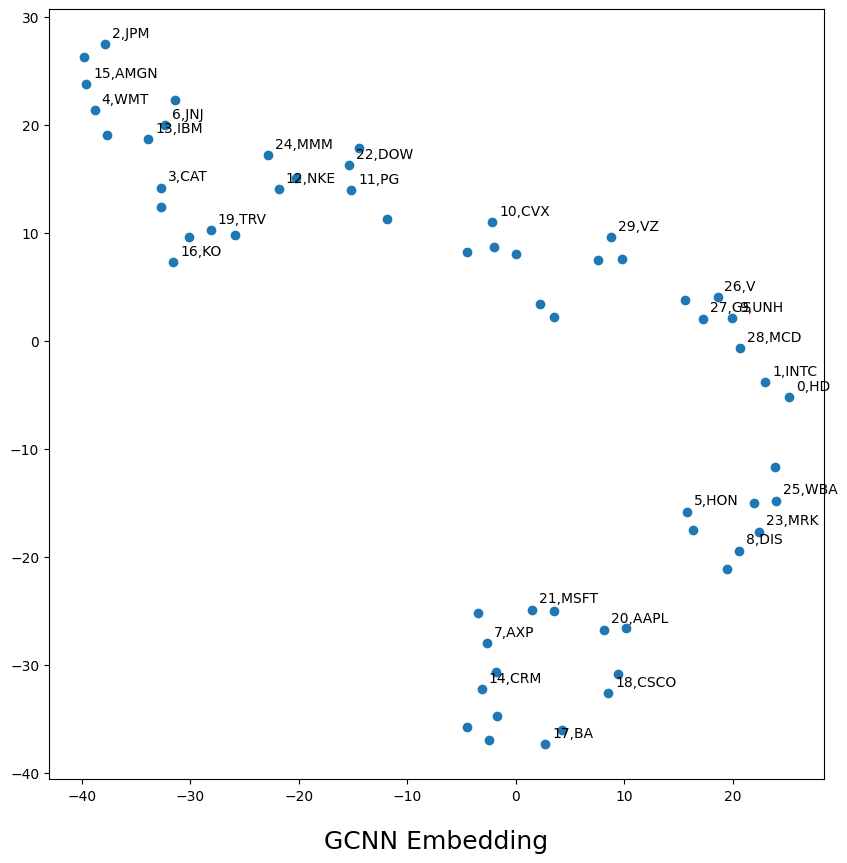

In [8]:
position = TSNE(n_components=2,perplexity=5).fit_transform(seq_gcnn_embedding[0])
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(position[:,0],position[:,1])

ax.set_title('GCNN Embedding', fontsize=18,y=-0.1)

for i, txt in enumerate(TICKERS):
    ax.annotate(str(i)+','+txt, (position[i,0], position[i,1]), xytext=(5,5), textcoords='offset points')
    # print(str(i),txt)
    # for j, txt_j in enumerate(TICKERS):
    #     if all(position[i]== position[j]) and i!=j: 
    #         print('equivalent:',j,txt_j)


plt.show()

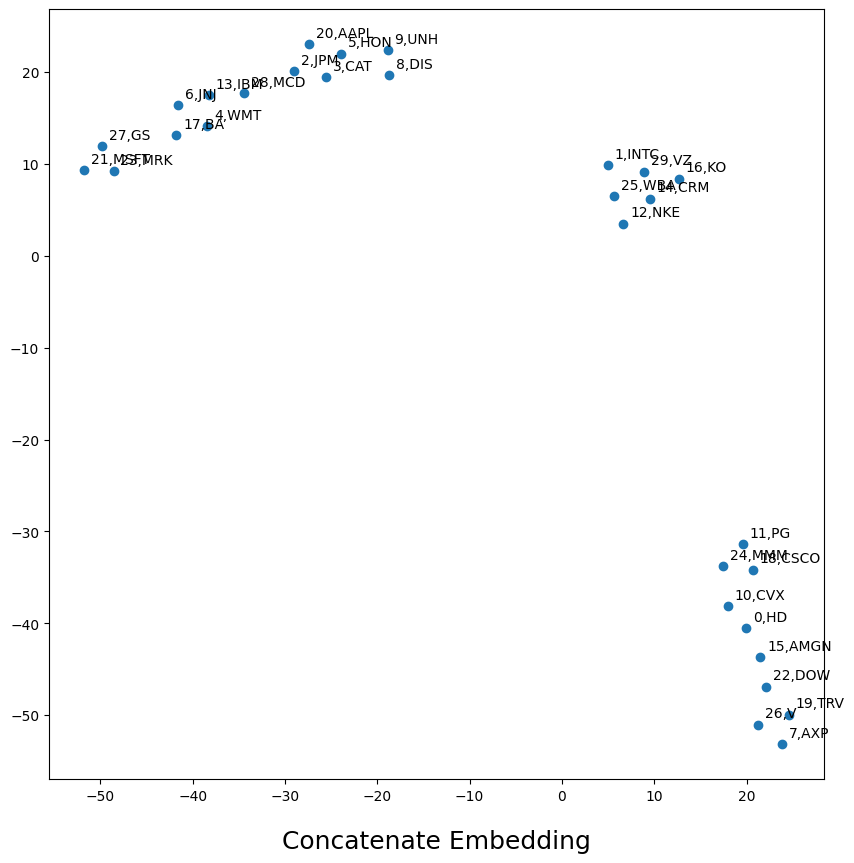

In [9]:
position = TSNE(n_components=2,perplexity=5).fit_transform(seq_graph_embedding[0])
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(position[:,0],position[:,1])

ax.set_title('Concatenate Embedding', fontsize=18,y=-0.1)

for i, txt in enumerate(TICKERS):
    ax.annotate(str(i)+','+txt, (position[i,0], position[i,1]), xytext=(5,5), textcoords='offset points')
    # print(str(i),txt)
    # for j, txt_j in enumerate(TICKERS):
    #     if all(position[i]== position[j]) and i!=j: 
    #         print('equivalent:',j,txt_j)


plt.show()


0 HD
1 INTC
2 JPM
3 CAT
equivalent: 5 HON
equivalent: 7 AXP
equivalent: 11 PG
equivalent: 12 NKE
equivalent: 13 IBM
equivalent: 14 CRM
equivalent: 16 KO
4 WMT
5 HON
equivalent: 3 CAT
equivalent: 7 AXP
equivalent: 11 PG
equivalent: 12 NKE
equivalent: 13 IBM
equivalent: 14 CRM
equivalent: 16 KO
6 JNJ
7 AXP
equivalent: 3 CAT
equivalent: 5 HON
equivalent: 11 PG
equivalent: 12 NKE
equivalent: 13 IBM
equivalent: 14 CRM
equivalent: 16 KO
8 DIS
9 UNH
10 CVX
11 PG
equivalent: 3 CAT
equivalent: 5 HON
equivalent: 7 AXP
equivalent: 12 NKE
equivalent: 13 IBM
equivalent: 14 CRM
equivalent: 16 KO
12 NKE
equivalent: 3 CAT
equivalent: 5 HON
equivalent: 7 AXP
equivalent: 11 PG
equivalent: 13 IBM
equivalent: 14 CRM
equivalent: 16 KO
13 IBM
equivalent: 3 CAT
equivalent: 5 HON
equivalent: 7 AXP
equivalent: 11 PG
equivalent: 12 NKE
equivalent: 14 CRM
equivalent: 16 KO
14 CRM
equivalent: 3 CAT
equivalent: 5 HON
equivalent: 7 AXP
equivalent: 11 PG
equivalent: 12 NKE
equivalent: 13 IBM
equivalent: 16 KO
15 AMG

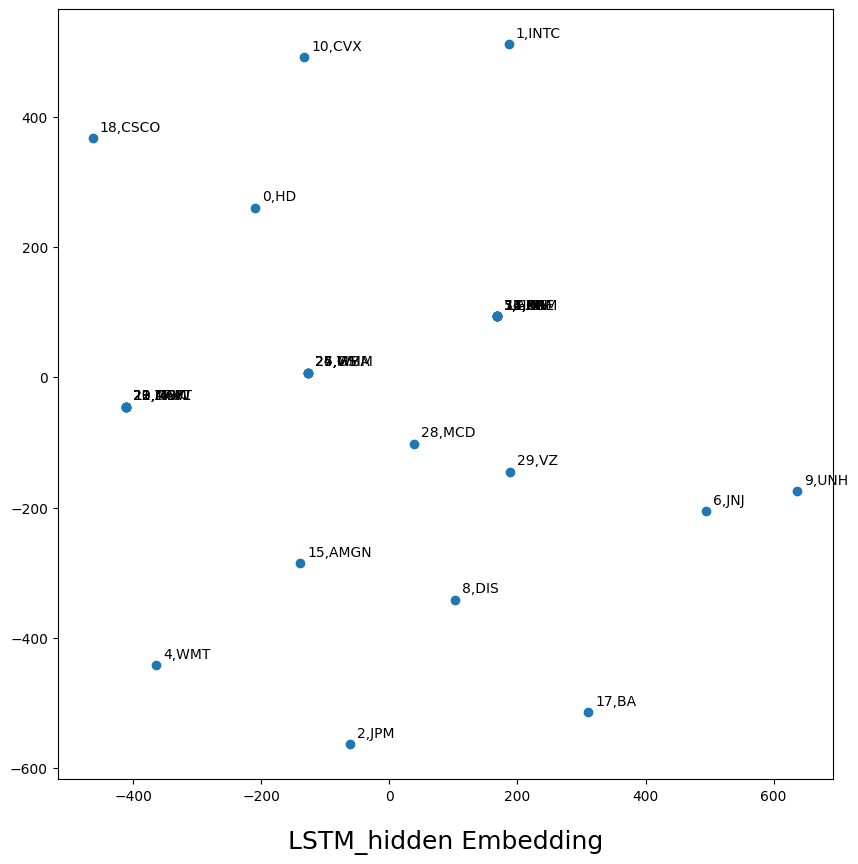

In [10]:
position = TSNE(n_components=2,perplexity=5).fit_transform(lstm_hidden_embedding)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(position[:,0],position[:,1])

ax.set_title('LSTM_hidden Embedding', fontsize=18,y=-0.1)

for i, txt in enumerate(TICKERS):
    ax.annotate(str(i)+','+txt, (position[i,0], position[i,1]), xytext=(5,5), textcoords='offset points')
    print(str(i),txt)
    for j, txt_j in enumerate(TICKERS):
        if all(position[i]== position[j]) and i!=j: 
            print('equivalent:',j,txt_j)


plt.show()

# fig, ax = plt.subplots(figsize=(10,10))
# ax.scatter(position[:,0],position[:,1])
# self_dist = paired_distances(position[0],position[1])
# unchanged_idx = np.arange(30)[self_dist<5]

# ax.set_title('Node2Vec Embedding', fontsize=18,y=-0.1)
# for i, txt in enumerate(TICKERS):
#     ax.annotate(txt, (position[1,i,0], position[1,i,1]), xytext=(5,5), textcoords='offset points')

# ax.scatter(position[0,unchanged_idx,0],position[0,unchanged_idx,1],c='r',alpha=0.3)
# for i in unchanged_idx:
#     txt = TICKERS[i]

#     ax.annotate(txt, (position[0,i,0], position[0,i,1]), xytext=(5,5), textcoords='offset points',color ='red',alpha=0.3 )